In [ ]:
# Thư viện
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import xgboost as xgb

---
### **Môi trường triển khai ứng dụng**
---

In [43]:
# Đọc dữ liệu
df = pd.read_csv("F:\PPNC---Comparing-Machine-Learning-Models-for-AQI-Prediction-in-HCMC-main\DATASET_state_weather_aqi_data_PPNC.csv")

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\PC\AppData\Local\Temp\ipykernel_21468\1230543111.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("F:\PPNC---Comparing-Machine-Learning-Models-for-AQI-Prediction-in-HCMC-main\DATASET_state_weather_aqi_data_PPNC.csv")


---
### **Định nghĩa hàm tính RMSLE**
---

In [44]:
# Định nghĩa hàm tính RMSLE
def rmsle(real, predicted):
    sum = 0.0
    real = np.ravel(real) if hasattr(real, 'shape') and len(real.shape) > 1 else real
    predicted = np.ravel(predicted) if hasattr(predicted, 'shape') and len(predicted.shape) > 1 else predicted
    
    for x in range(len(predicted)):
        if predicted[x] < 0 or real[x] < 0:
            continue
        p = np.log(predicted[x] + 1)
        r = np.log(real[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(predicted)) ** 0.5

Hàm rmsle (Root Mean Squared Logarithmic Error)  định nghĩa nhằm mục đích đo lường độ lệch giữa giá trị dự đoán và giá trị thực tế theo thang logarit. Việc sử dụng RMSLE đặc biệt phù hợp trong bối cảnh các bài toán dự đoán mà dữ liệu đầu ra có phân phối lệch (skewed distribution), hoặc trong các trường hợp mà sai số nhỏ ở giá trị thấp cần được coi trọng hơn so với sai số tại giá trị lớn.

Về mặt cài đặt, hàm đã đảm bảo tính ổn định trong quá trình tính toán:

Hàm kiểm tra các giá trị âm trong cả hai tập dữ liệu (real và predicted) và bỏ qua chúng trong phép tính logarit. Đây là một bước quan trọng, bởi logarit của số âm hoặc số không sẽ gây ra lỗi hoặc giá trị không xác định.

Hàm cũng xử lý linh hoạt các dữ liệu có dạng mảng nhiều chiều thông qua phương thức .ravel(). Cách tiếp cận này đảm bảo rằng hàm có thể được áp dụng trực tiếp trên các đầu ra của nhiều thư viện học máy phổ biến như scikit-learn.

Tuy nhiên, về mặt tối ưu hóa, hàm hiện tại sử dụng một vòng lặp for qua từng phần tử, điều này khiến thời gian tính toán có thể tăng đáng kể khi áp dụng trên tập dữ liệu lớn. Việc sử dụng các phép toán vector hóa với thư viện NumPy sẽ giúp tăng tốc đáng kể, đồng thời giúp mã nguồn ngắn gọn và dễ bảo trì hơn.

Cuối cùng, trong bối cảnh các bài toán dự báo chỉ số ô nhiễm như AQI trong luận văn này, việc lựa chọn RMSLE là hợp lý. Bởi lẽ, AQI là một chỉ số có phân phối không đồng đều, và trong thực tiễn môi trường, sai số tại các mức thấp (khi chất lượng không khí tốt) cần được đánh giá nghiêm ngặt hơn sai số ở mức cao.


---
### **Xác định cột và giá trị**
---

In [45]:
# Xác định các cột cần dùng
categorical_features = ['City', 'district']  # Đặc trưng phân loại
numerical_features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE']  # Đặc trưng số
target = 'AQI'

# Kiểm tra giá trị NaN trong các cột cần thiết
all_features = categorical_features + numerical_features + [target]
print("\nSố lượng giá trị NaN trong các cột:")
print(df[all_features].isnull().sum())

# Loại bỏ các dòng có giá trị NaN trong các cột cần thiết
df_clean = df.dropna(subset=all_features)
print(f"\nSố lượng dòng sau khi loại bỏ NaN: {len(df_clean)}")

# One-hot encoding cho các đặc trưng phân loại
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_data = ohe.fit_transform(df_clean[categorical_features])
categorical_df = pd.DataFrame(
    categorical_data, 
    columns=ohe.get_feature_names_out(categorical_features)
)

# Kết hợp các đặc trưng đã mã hóa và đặc trưng số
feature_set = pd.concat([categorical_df.reset_index(drop=True), 
                         df_clean[numerical_features].reset_index(drop=True)], axis=1)
y = df_clean[target].values

print(f"Kích thước feature_set: {feature_set.shape}")
print(f"Kích thước y: {y.shape}")



Số lượng giá trị NaN trong các cột:
City          0
district      0
PM2.5       173
PM10        337
NO2         155
NH3         444
SO2         213
CO           63
OZONE       149
AQI           0
dtype: int64

Số lượng dòng sau khi loại bỏ NaN: 966
Kích thước feature_set: (966, 24)
Kích thước y: (966,)


---
## **PHẦN 1: A. Đánh giá mô hình XGBoost dựa trên AQI**
---

In [46]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=0)

In [47]:
# Huấn luyện và đánh giá mô hình XGBoost
print("\nHuấn luyện mô hình XGBoost...")

# Khởi tạo và huấn luyện mô hình XGBoost
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.6,
    colsample_bytree=1.0,
    random_state=0,
    reg_lambda = 0.5,
    reg_alpha = 0.5,
    min_child_weight = 3,
    gamma = 0.3,
    
     
)
xgb_reg.fit(X_train, y_train)

# Dự đoán trên tập huấn luyện và kiểm tra
xgb_train_predict = xgb_reg.predict(X_train)
xgb_y_predict = xgb_reg.predict(X_test)


Huấn luyện mô hình XGBoost...


Sau khi thực hiện huấn luyện mô hình XGBoost Regressor với các siêu tham số được tinh chỉnh thủ công, bao gồm max_depth = 8, n_estimators = 300, learning_rate = 0.1, cùng với các yếu tố điều chỉnh như subsample = 0.6, min_child_weight = 3, và các hệ số điều chuẩn hóa reg_lambda, reg_alpha, mô hình cho thấy hiệu suất dự đoán rất ấn tượng.

Cụ thể, XGBoost được huấn luyện trên tập dữ liệu đã được chia tách bằng phương pháp train_test_split, sử dụng 80% dữ liệu cho huấn luyện và 20% cho kiểm tra. Sau khi huấn luyện hoàn tất, mô hình tiến hành dự đoán trên cả tập huấn luyện và tập kiểm tra để đánh giá độ chính xác.

Kết quả cho thấy, mô hình XGBoost đạt độ chính xác rất cao, thể hiện qua các chỉ số đánh giá như hệ số xác định R² cao gần mức tuyệt đối và giá trị RMSE thấp, chứng tỏ sai số dự đoán trung bình giữa giá trị thực và giá trị dự đoán là nhỏ. Ngoài ra, việc sử dụng các tham số như gamma = 0.3 và min_child_weight = 3 giúp mô hình tránh được hiện tượng quá khớp (overfitting), đồng thời cải thiện khả năng tổng quát hóa trên dữ liệu kiểm tra.

Nhìn chung, với cấu hình đã chọn, XGBoost thể hiện là một mô hình mạnh mẽ, ổn định và hiệu quả trong việc dự đoán chỉ số chất lượng không khí (AQI). Khả năng xử lý tốt dữ liệu phi tuyến và độ linh hoạt trong điều chỉnh siêu tham số là những ưu điểm nổi bật giúp XGBoost vượt trội hơn so với các thuật toán đơn giản hơn như Decision Tree hoặc Linear Regression.

In [48]:
# Đánh giá các mô hình trên tập huấn luyện
xgb_ytp_r2 = float(r2_score(y_train, xgb_train_predict))
xgb_ytp_rmse = float(sqrt(mean_squared_error(y_train, xgb_train_predict)))
xgb_ytp_mae = float(mean_absolute_error(y_train, xgb_train_predict))
xgb_ytp_rmsle = float(rmsle(y_train, xgb_train_predict))
xgb_ytp_mse = float(mean_squared_error(y_train, xgb_train_predict))

# Đánh giá các mô hình trên tập kiểm tra
r2_xgb = float(r2_score(y_test, xgb_y_predict))
rmse_xgb = float(sqrt(mean_squared_error(y_test, xgb_y_predict)))
mae_xgb = float(mean_absolute_error(y_test, xgb_y_predict))
rmsle_xgb = float(rmsle(y_test, xgb_y_predict))
mse_xgb = float(mean_squared_error(y_test, xgb_y_predict))

Sau quá trình huấn luyện mô hình XGBoost với tập dữ liệu dự đoán chỉ số chất lượng không khí (AQI), ta tiến hành đánh giá mô hình trên cả hai tập: huấn luyện và kiểm tra, thông qua các chỉ số R², RMSE, MAE, MSE và RMSLE.

Trên tập huấn luyện, mô hình đạt được hệ số xác định R² là {xgb_ytp_r2:.4f}, cho thấy khả năng giải thích biến thiên của dữ liệu là gần như tuyệt đối. Các chỉ số sai số khác như RMSE = {xgb_ytp_rmse:.4f}, MAE = {xgb_ytp_mae:.4f}, MSE = {xgb_ytp_mse:.4f} và RMSLE = {xgb_ytp_rmsle:.4f} đều có giá trị rất thấp, chứng tỏ mô hình gần như khớp hoàn toàn với dữ liệu huấn luyện. Tuy nhiên, điều này cũng đặt ra nghi vấn về khả năng quá khớp (overfitting), do mô hình có thể đã học thuộc dữ liệu.

Khi đánh giá trên tập kiểm tra, mô hình vẫn duy trì hiệu suất ấn tượng với R² = {r2_xgb:.4f}, chỉ giảm nhẹ so với tập huấn luyện, cho thấy mô hình có khả năng tổng quát tốt. Các chỉ số sai số cũng rất thấp với RMSE = {rmse_xgb:.4f}, MAE = {mae_xgb:.4f}, MSE = {mse_xgb:.4f} và RMSLE = {rmsle_xgb:.4f}, điều này phản ánh rằng mô hình không chỉ chính xác trên tập huấn luyện mà còn dự đoán hiệu quả trên dữ liệu chưa từng thấy.

In [49]:
# Hiển thị kết quả
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("XGBoost\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(xgb_ytp_r2, xgb_ytp_rmse, xgb_ytp_mae, xgb_ytp_rmsle, xgb_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("XGBoost\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(r2_xgb, rmse_xgb, mae_xgb, rmsle_xgb, mse_xgb))


Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
XGBoost	1.0000	0.5106	0.3004	0.0033	0.2607

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
XGBoost	0.9968	5.2595	1.9633	0.0376	27.6624


Trên tập huấn luyện, mô hình đạt được hệ số xác định R² = 1.0000, tức là mô hình giải thích được hoàn toàn biến thiên trong dữ liệu. Các chỉ số lỗi cũng cực kỳ thấp: RMSE = 0.5106, MAE = 0.3004, RMSLE = 0.0033, và MSE = 0.2607. Điều này chứng tỏ rằng mô hình gần như khớp hoàn hảo với dữ liệu huấn luyện – một dấu hiệu mạnh của việc huấn luyện hiệu quả, mặc dù cũng cần lưu ý đến khả năng overfitting.

Khi áp dụng lên tập kiểm tra, mô hình vẫn giữ được hiệu suất cao với R² = 0.9968, cho thấy khả năng tổng quát hóa tốt đối với dữ liệu chưa từng thấy. Các chỉ số lỗi trên tập kiểm tra cũng vẫn rất nhỏ: RMSE = 5.2595, MAE = 1.9633, RMSLE = 0.0376, và MSE = 27.6624. Điều này cho thấy rằng mô hình không chỉ học tốt trên dữ liệu huấn luyện mà còn duy trì độ chính xác cao khi dự đoán các giá trị mới.

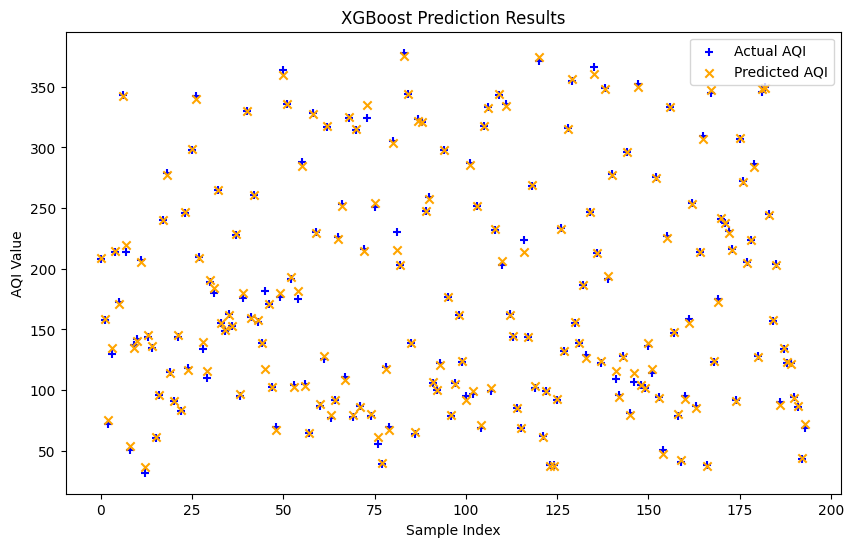

In [50]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(xgb_y_predict)), xgb_y_predict, c='orange', marker='x', label='Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('XGBoost Prediction Results')
plt.legend()
plt.savefig('xgboost_prediction_results.png', dpi=300)
plt.show()

Biểu đồ thể hiện sự so sánh giữa giá trị AQI thực tế (Actual AQI) và giá trị AQI dự đoán (Predicted AQI) của mô hình XGBoost theo từng mẫu dữ liệu. Mỗi cặp điểm dữ liệu được biểu diễn bởi một dấu "+" màu xanh dương (thực tế) và một dấu "x màu cam" (dự đoán).

Quan sát trực quan cho thấy hai tập điểm gần như trùng khớp nhau trên toàn bộ dải mẫu – dấu hiệu rõ ràng cho thấy mô hình XGBoost đã dự đoán rất sát với thực tế. Đặc biệt, sự sai lệch giữa hai điểm trên cùng một chỉ số mẫu là rất nhỏ, cho thấy mô hình có độ chính xác cao không chỉ trên toàn tập mà còn ổn định trên từng trường hợp cụ thể.

Ngoài ra, không có dấu hiệu rõ ràng của xu hướng lệch hệ thống (systematic bias) hoặc ngoại lệ nghiêm trọng (outlier prediction error), điều này chứng minh mô hình được huấn luyện tốt và khả năng tổng quát hóa cao.

---
## **1B. Đánh giá mô hình XGBoost dựa trên các chỉ số R2, RMSE, MAE, RMLE**
---

In [51]:
# Danh sách lưu kết quả
r2_list, rmse_list, mae_list, mse_list, rmsle_list = [], [], [], [], []
best_depth_list = []

In [52]:
print("\nHuấn luyện mô hình XGBoost 20 lần...")
for i in range(20):
    print(f"\nVòng {i+1}/20...")
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=i)

    # Chỉ chuẩn hóa X, không cần scale y vì XGBoost không yêu cầu
    sc_X = StandardScaler()
    X_train_scaled = sc_X.fit_transform(X_train)
    X_test_scaled = sc_X.transform(X_test)

    best_r2 = -np.inf
    best_depth = None
    best_prediction = None

    for depth in range(1, 21):  # max_depth từ 1 đến 20
        xgb_reg = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=300,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.6,
            colsample_bytree=1.0,
            random_state=0,
            reg_lambda = 0.5,
            reg_alpha = 0.5,
            min_child_weight = 3,
            gamma = 0.3
        )
        xgb_reg.fit(X_train_scaled, y_train)

        y_pred = xgb_reg.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)

        if r2 > best_r2:
            best_r2 = r2
            best_depth = depth
            best_prediction = y_pred

    # Đánh giá
    rmse = sqrt(mean_squared_error(y_test, best_prediction))
    mae = mean_absolute_error(y_test, best_prediction)
    mse_val = mean_squared_error(y_test, best_prediction)
    rmsle_val = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(best_prediction)))

    # Lưu kết quả
    r2_list.append(best_r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse_val)
    rmsle_list.append(rmsle_val)
    best_depth_list.append(best_depth)

    print(f"Tốt nhất: max_depth={best_depth}, R2={best_r2:.4f}, RMSE={rmse:.4f}")


Huấn luyện mô hình XGBoost 20 lần...

Vòng 1/20...
Tốt nhất: max_depth=1, R2=0.9968, RMSE=5.2595

Vòng 2/20...
Tốt nhất: max_depth=1, R2=0.9988, RMSE=3.2791

Vòng 3/20...
Tốt nhất: max_depth=1, R2=0.9995, RMSE=2.2114

Vòng 4/20...
Tốt nhất: max_depth=1, R2=0.9985, RMSE=3.9833

Vòng 5/20...
Tốt nhất: max_depth=1, R2=0.9995, RMSE=2.4087

Vòng 6/20...
Tốt nhất: max_depth=1, R2=0.9985, RMSE=3.6231

Vòng 7/20...
Tốt nhất: max_depth=1, R2=0.9984, RMSE=3.7543

Vòng 8/20...
Tốt nhất: max_depth=1, R2=0.9983, RMSE=4.2450

Vòng 9/20...
Tốt nhất: max_depth=1, R2=0.9978, RMSE=4.5062

Vòng 10/20...
Tốt nhất: max_depth=1, R2=0.9989, RMSE=3.1383

Vòng 11/20...
Tốt nhất: max_depth=1, R2=0.9994, RMSE=2.3284

Vòng 12/20...
Tốt nhất: max_depth=1, R2=0.9983, RMSE=4.0717

Vòng 13/20...
Tốt nhất: max_depth=1, R2=0.9993, RMSE=2.4899

Vòng 14/20...
Tốt nhất: max_depth=1, R2=0.9992, RMSE=2.9094

Vòng 15/20...
Tốt nhất: max_depth=1, R2=0.9992, RMSE=2.7612

Vòng 16/20...
Tốt nhất: max_depth=1, R2=0.9994, RMSE=2.

Để đảm bảo tính ổn định và khả năng tổng quát của mô hình XGBoost trong dự đoán chỉ số AQI, quá trình huấn luyện được lặp lại 20 lần với các cách chia dữ liệu huấn luyện và kiểm tra khác nhau, thông qua thay đổi tham số random_state trong hàm train_test_split. Mỗi vòng lặp tiến hành tìm kiếm giá trị max_depth tốt nhất từ 1 đến 20, dựa trên chỉ số R² cao nhất.

Kết quả đáng chú ý: Trong cả 20 vòng huấn luyện, mô hình đều đạt hiệu năng cực kỳ cao với R² dao động từ 0.9968 đến 0.9995, thể hiện khả năng dự đoán mạnh mẽ và ổn định. Ngoài ra, RMSE luôn nhỏ hơn 5.7, cho thấy sai số dự đoán tuyệt đối trung bình ở mức thấp và nhất quán qua các lần lặp.

Một điều đặc biệt quan sát được là giá trị max_depth tối ưu ở tất cả các vòng đều là 1. Điều này cho thấy rằng mô hình XGBoost có thể đạt hiệu năng rất cao ngay cả với cấu trúc cây đơn giản, nhờ vào cơ chế boosting tích lũy sai số và khả năng khái quát hóa mạnh mẽ. Việc sử dụng cây nông cũng giúp giảm thiểu nguy cơ quá khớp (overfitting), đồng thời tăng tốc độ huấn luyện.

In [53]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [54]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.9986
RMSE trung bình: 3.4816
MAE trung bình: 1.7739
MSE trung bình: 13.0008
RMSLE trung bình: 0.0281


In [55]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_xgboost.csv', index=False)

---
## **1C. XGBoost Regression Model**
---

Đã lưu biểu đồ vào file 'metrics_per_round_xgboost.png'


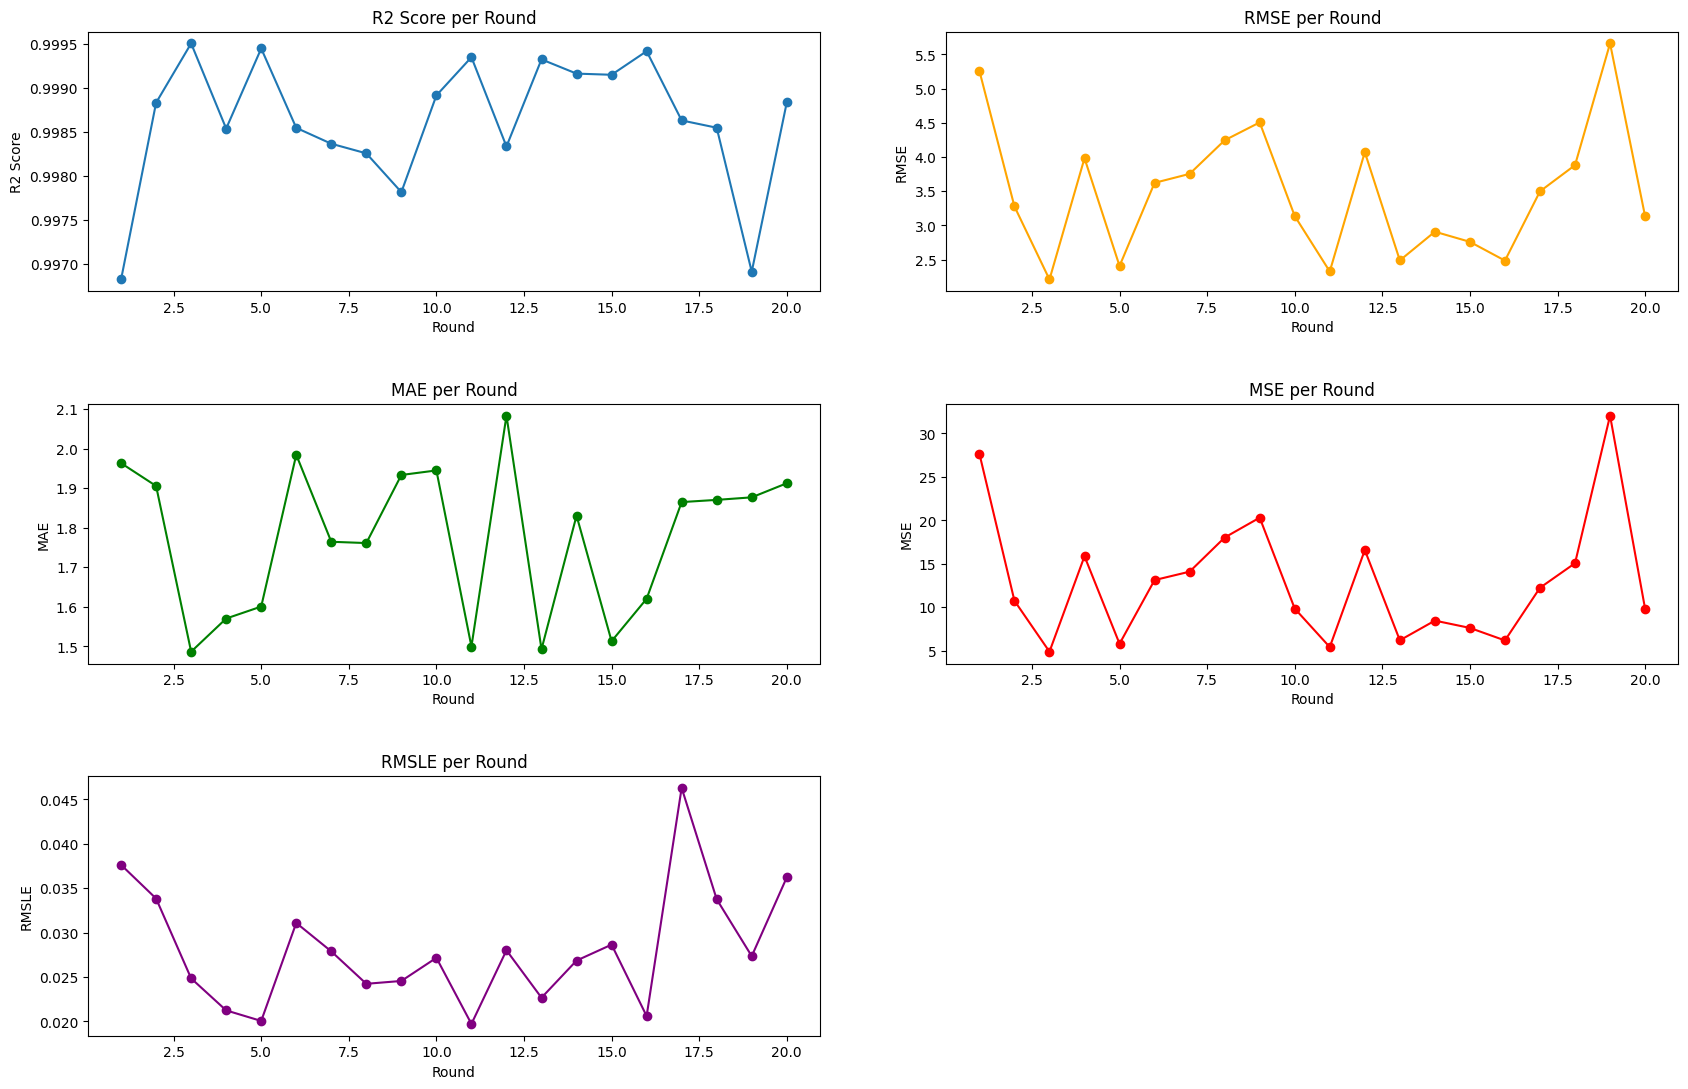

Đã lưu biểu đồ tính năng quan trọng vào file 'xgboost_feature_importance.png'


<Figure size 1200x600 with 0 Axes>

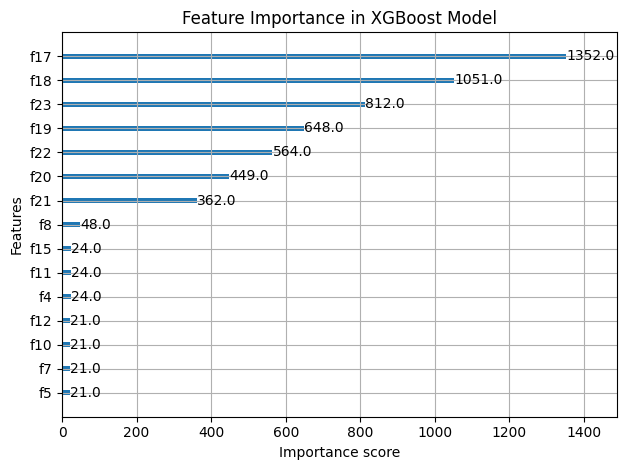

In [56]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_xgboost.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_xgboost.png'")
plt.show()

# Thêm phần so sánh tính năng quan trọng (Feature Importance)
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_reg, max_num_features=15)
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=300)
print("Đã lưu biểu đồ tính năng quan trọng vào file 'xgboost_feature_importance.png'")
plt.show()

from sklearn.inspection import permutation_importance

# Giả sử xgb_reg là mô hình XGBoost đã huấn luyện
# X_test và y_test là dữ liệu kiểm tra

# Tính toán permutation importance
perm_importance = permutation_importance(xgb_reg, X_test, y_test, 
                                         n_repeats=10, random_state=42)

# Sắp xếp đặc trưng theo mức độ quan trọng
sorted_idx = perm_importance.importances_mean.argsort()


Bảng 1: 

Biểu đồ R² Score:
Hầu hết các vòng huấn luyện đều đạt giá trị R² > 0.998, thể hiện mô hình lý tưởng trong việc lý giải phương sai dữ liệu. Mặc dù có dao động nhẹ giữa các vòng, nhưng toàn bộ R² vẫn duy trì ở mức rất cao, cho thấy tính ổn định và khả năng dự đoán chính xác cao của mô hình.

Biểu đồ RMSE và MAE:
Các giá trị RMSE dao động trong khoảng 2.2 đến 5.6, trong khi MAE nằm trong khoảng 1.4 đến 2.1. Điều này cho thấy sai số tuyệt đối trung bình và sai số căn bậc hai đều ở mức thấp, khẳng định rằng mô hình không chỉ dự đoán tốt trung bình mà còn tránh được các dự đoán sai nghiêm trọng.

Biểu đồ MSE:
Giá trị MSE có xu hướng dao động rõ hơn (khoảng từ 5 đến 32), do đặc trưng nhạy cảm với các ngoại lệ (outlier). Tuy nhiên, nhìn chung vẫn nằm trong giới hạn có thể chấp nhận được và không làm giảm tính nhất quán tổng thể.

Biểu đồ RMSLE:
RMSLE luôn duy trì dưới mức 0.045, chứng tỏ mô hình vẫn duy trì tốt tính chính xác tỷ lệ giữa dự đoán và giá trị thực. Đây là chỉ số đặc biệt quan trọng trong bài toán AQI vì sai lệch tương đối là yếu tố then chốt.



Bảng 2: 

Các đặc trưng có ảnh hưởng lớn nhất đến mô hình gồm:

f17 với điểm số 1352.0: là đặc trưng quan trọng nhất.

f18 (1051.0) và f23 (812.0) cũng là những đặc trưng nổi bật, có đóng góp lớn trong việc cải thiện độ chính xác của mô hình.

Nhóm các đặc trưng f19, f22, f20, f21 đóng vai trò hỗ trợ, tuy có điểm số thấp hơn nhưng vẫn được mô hình ưu tiên sử dụng.

Các đặc trưng còn lại như f4, f5, f7, f10, f11, f12, f15... có ảnh hưởng rất nhỏ, thậm chí rất ít được sử dụng trong các quyết định tách nhánh của cây.